<a href="https://colab.research.google.com/github/pgeorgantopoulos/phd/blob/main/NFvsCFMvsDDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

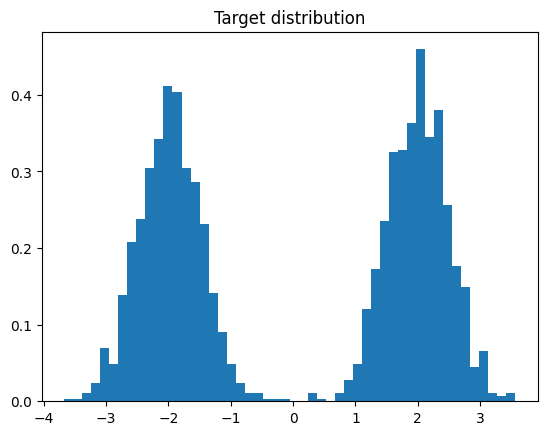

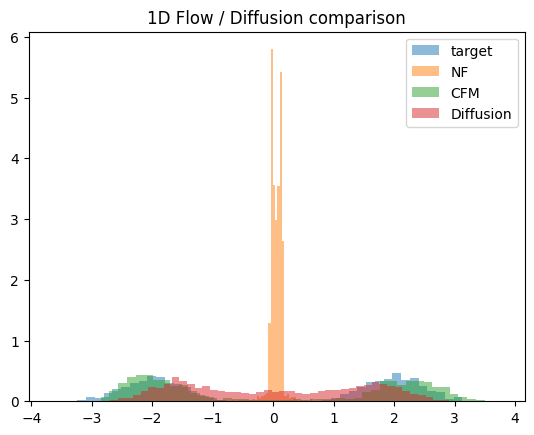

In [2]:
# Flow / Diffusion 1D comparison

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- Data: 1D mixture of Gaussians ---
def sample_data(n=1000):
    mix = torch.rand(n) < 0.5
    x = torch.zeros(n)
    x[mix] = torch.randn(mix.sum()) * 0.5 - 2
    x[~mix] = torch.randn((~mix).sum()) * 0.5 + 2
    return x.unsqueeze(1)

data = sample_data(2000)
plt.hist(data.numpy(), bins=50, density=True)
plt.title('Target distribution'); plt.show()

# --- Normalizing Flow (Planar Flow, 1D) ---
class PlanarFlow(nn.Module):
    def __init__(self):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1,1))
        self.w = nn.Parameter(torch.randn(1,1))
        self.b = nn.Parameter(torch.randn(1))
    def forward(self, z):
        # z -> x
        linear = z @ self.w.T + self.b
        x = z + self.u * torch.tanh(linear)
        return x

nf = PlanarFlow()
optimizer_nf = optim.Adam(nf.parameters(), lr=0.01)
z_base = torch.randn_like(data)

# Training NF (maximize likelihood via approximate method)
for i in range(1000):
    optimizer_nf.zero_grad()
    x_pred = nf(z_base)
    # simple regression to data (toy approximation)
    loss = ((x_pred - data)**2).mean()
    loss.backward()
    optimizer_nf.step()

# --- Conditional Flow Matching (linear path) ---
class CFM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2,32), nn.ReLU(), nn.Linear(32,1))
    def forward(self, x_t, t):
        inp = torch.cat([x_t, t], dim=1)
        return self.net(inp)

cfm = CFM()
optimizer_cfm = optim.Adam(cfm.parameters(), lr=0.01)

# Training CFM
for i in range(2000):
    optimizer_cfm.zero_grad()
    idx = torch.randint(0, data.shape[0], (64,))
    x = data[idx]
    z = torch.randn_like(x)
    t = torch.rand(64,1)
    x_t = (1-t)*z + t*x
    v = x - z
    v_pred = cfm(x_t, t)
    loss = ((v_pred - v)**2).mean()
    loss.backward()
    optimizer_cfm.step()

# --- Simple Diffusion (Euler-Maruyama) ---
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2,32), nn.ReLU(), nn.Linear(32,1))
    def forward(self, x_t, t):
        inp = torch.cat([x_t, t], dim=1)
        return self.net(inp)

dm = DiffusionModel()
optimizer_dm = optim.Adam(dm.parameters(), lr=0.01)

# Forward diffusion: add Gaussian noise
def q_xt(x0, t):
    std = t
    eps = torch.randn_like(x0)
    return x0 + std*eps, eps

# Training diffusion (denoising score matching)
for i in range(2000):
    optimizer_dm.zero_grad()
    idx = torch.randint(0, data.shape[0], (64,))
    x0 = data[idx]
    t = torch.rand(64,1)*0.5 + 0.01  # t in (0,0.5]
    x_t, eps = q_xt(x0, t)
    score_pred = dm(x_t, t)
    loss = ((score_pred + eps/t)**2).mean()
    loss.backward()
    optimizer_dm.step()

# --- Sampling ---
with torch.no_grad():
    # NF
    z = torch.randn(2000,1)
    x_nf = nf(z).numpy()
    # CFM (Euler ODE)
    x_cfm = torch.randn(2000,1)
    steps = 50
    for s in range(steps):
        t = torch.ones_like(x_cfm)*(s/steps)
        x_cfm = x_cfm + (cfm(x_cfm, t)/steps)
    x_cfm = x_cfm.numpy()
    # Diffusion (Euler-Maruyama reverse)
    x_dm = torch.randn(2000,1)
    dt = 0.01
    for s in range(50,0,-1):
        t = torch.ones_like(x_dm)*(s/50*0.5)
        score = dm(x_dm, t)
        x_dm = x_dm + score*dt + torch.sqrt(torch.tensor(dt, dtype=x_dm.dtype, device=x_dm.device))*torch.randn_like(x_dm)
    x_dm = x_dm.numpy()

# --- Plot results ---
plt.hist(data.numpy(), bins=50, density=True, alpha=0.5, label='target')
plt.hist(x_nf, bins=50, density=True, alpha=0.5, label='NF')
plt.hist(x_cfm, bins=50, density=True, alpha=0.5, label='CFM')
plt.hist(x_dm, bins=50, density=True, alpha=0.5, label='Diffusion')
plt.legend(); plt.title('1D Flow / Diffusion comparison'); plt.show()
